## Importing the libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


## Load the dataset

In [35]:
df = pd.read_csv('housing.csv')
print("Shape:", df.shape)
df.head()

Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Print information about the dataset

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## box plot


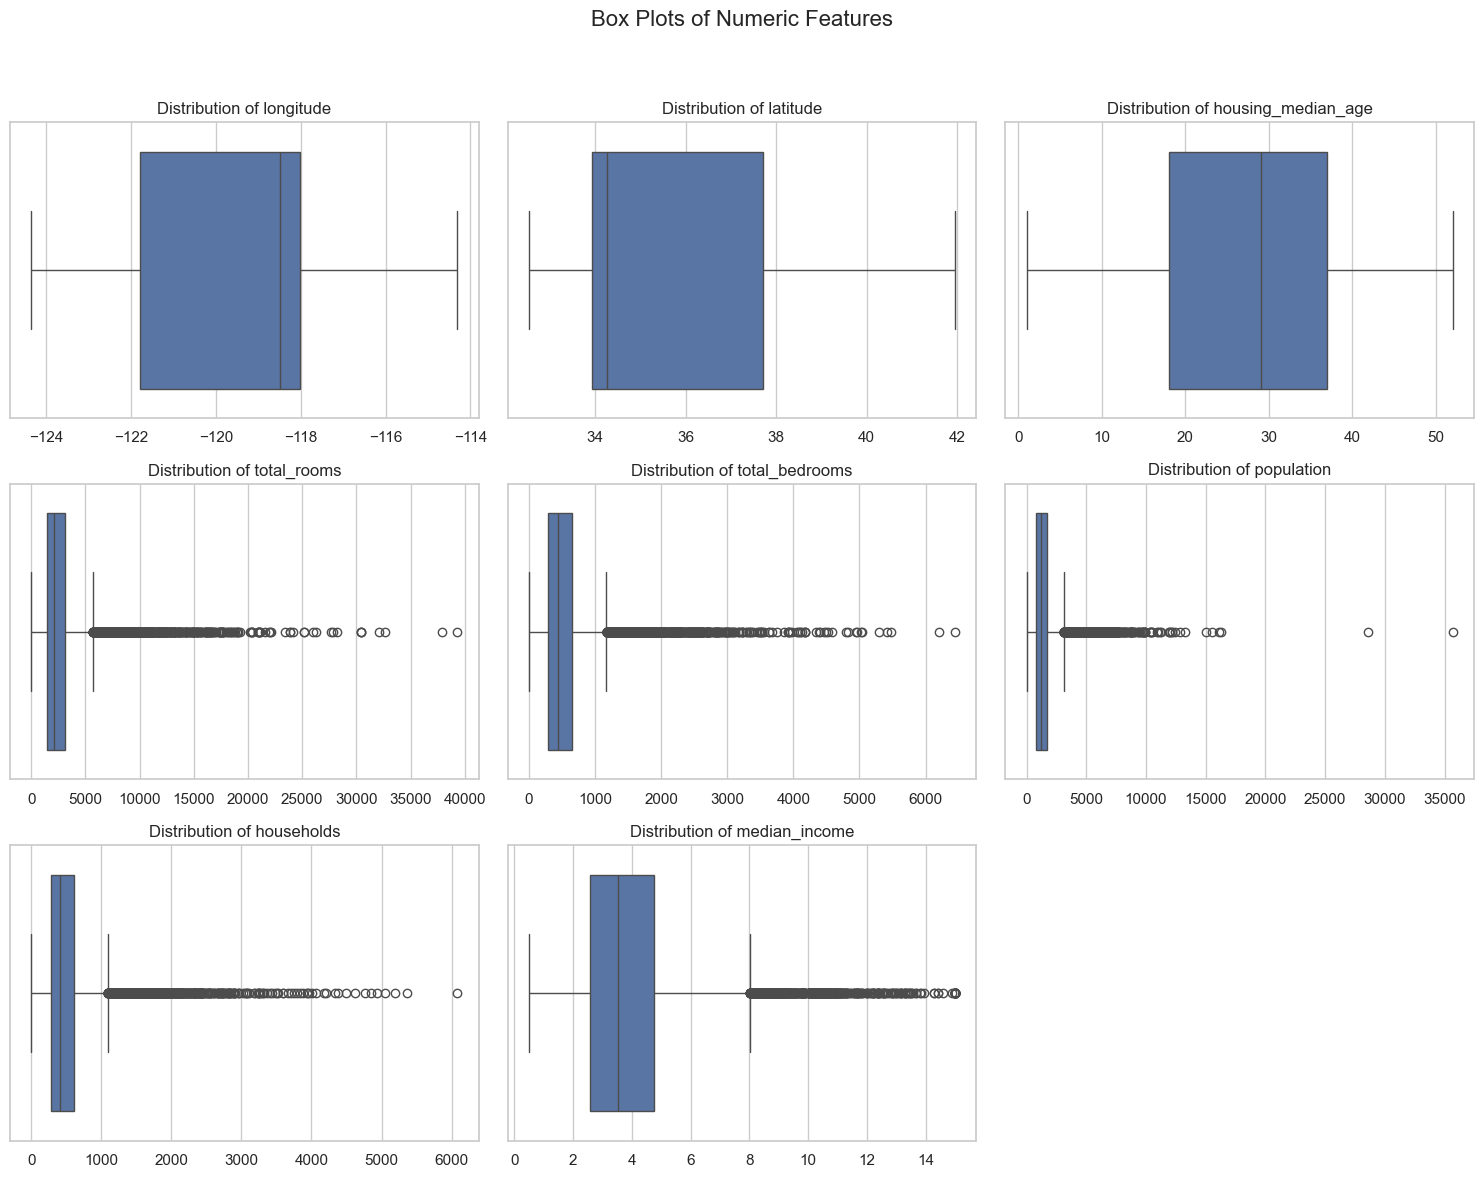

In [37]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
target_column = "median_house_value"
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if target_column in numeric_features:
    numeric_features.remove(target_column)
n_features = len(numeric_features)
n_cols = 3  
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle("Box Plots of Numeric Features", fontsize=16)
if n_rows > 1:
    axes = axes.flatten()
elif n_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]
for i, feature in enumerate(numeric_features):
    if i < len(axes):  
        sns.boxplot(x=df[feature], ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel('')
for i in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


## Distribution of target variable

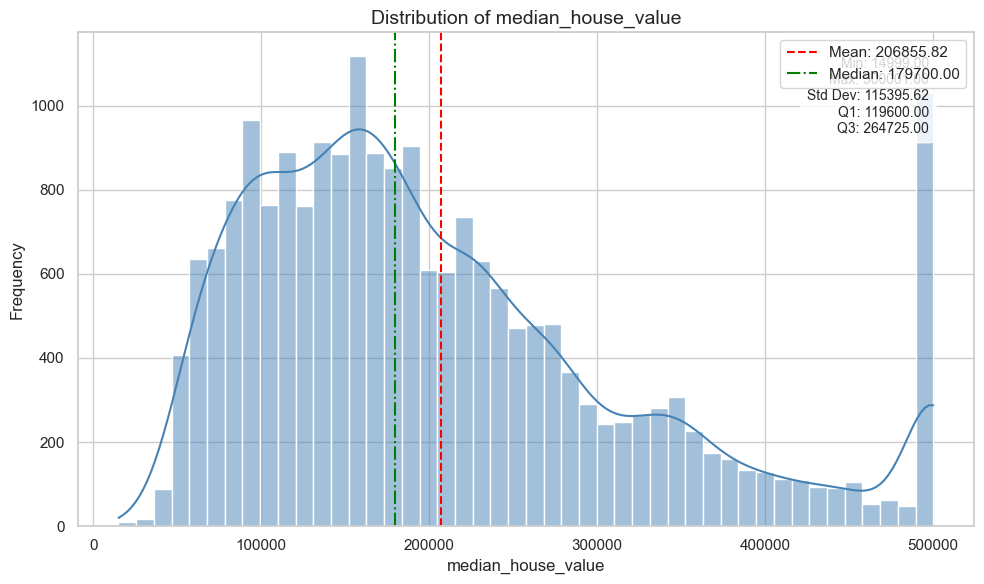

In [38]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(df[target_column], kde=True, color='steelblue')
mean_val = df[target_column].mean()
median_val = df[target_column].median()

plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='-.', label=f'Median: {median_val:.2f}')
stats_text = (
    f"Min: {df[target_column].min():.2f}\n"
    f"Max: {df[target_column].max():.2f}\n"
    f"Std Dev: {df[target_column].std():.2f}\n"
    f"Q1: {df[target_column].quantile(0.25):.2f}\n"
    f"Q3: {df[target_column].quantile(0.75):.2f}"
)
plt.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction',
            fontsize=10, bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
            ha='right', va='top')

plt.title(f"Distribution of {target_column}", fontsize=14)
plt.xlabel(target_column)
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## check if there any missing value

In [39]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


## Handle missing numerical values with mean

In [40]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())

## Another check

In [41]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


## Convert categorical feature into numerical values

In [42]:
le =LabelEncoder()
df['ocean_proximity'] =le.fit_transform(df['ocean_proximity'])


## Illustrate the relations between features and the taget column

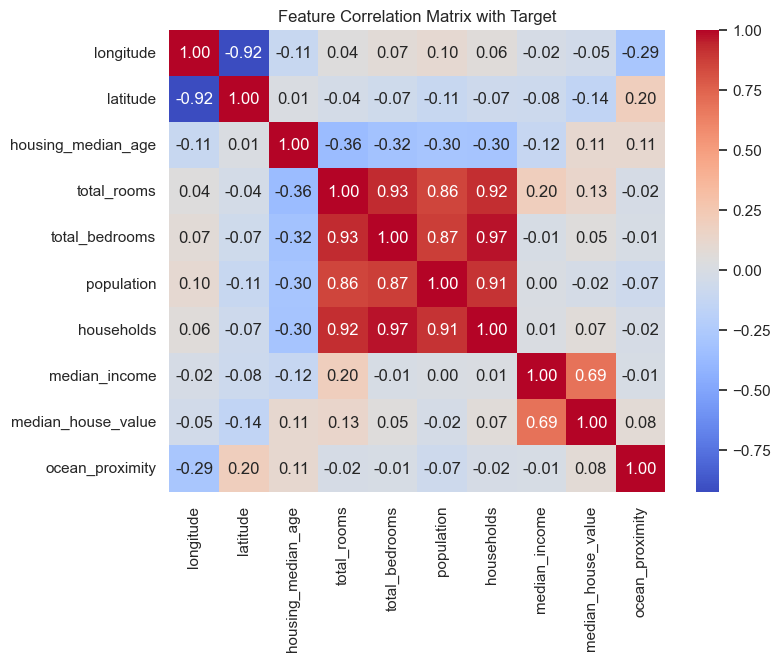

In [43]:
target_column = "median_house_value"
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix with Target")
plt.show()


## Show the value of the relation

In [44]:

target_corr = correlation_matrix[target_column].drop(target_column).sort_values(ascending=False)

print("\nTop positively correlated features with target:")
print(target_corr[target_corr > 0])

print("\nTop negatively correlated features with target:")
print(target_corr[target_corr < 0])




Top positively correlated features with target:
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
ocean_proximity       0.081750
households            0.065843
total_bedrooms        0.049454
Name: median_house_value, dtype: float64

Top negatively correlated features with target:
population   -0.024650
longitude    -0.045967
latitude     -0.144160
Name: median_house_value, dtype: float64


## Select most important features

In [45]:

threshold = 0.01
important_features = target_corr[abs(target_corr) > threshold].index.tolist()

print("\nSelected important features (|correlation| > 0.1):")
print(important_features)



Selected important features (|correlation| > 0.1):
['median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity', 'households', 'total_bedrooms', 'population', 'longitude', 'latitude']


## Update the dataframe

In [46]:


df = df[important_features+ [target_column]]


print("\nRemaining columns in the dataset after dropping the specified features:")
print(df.columns)



Remaining columns in the dataset after dropping the specified features:
Index(['median_income', 'total_rooms', 'housing_median_age', 'ocean_proximity',
       'households', 'total_bedrooms', 'population', 'longitude', 'latitude',
       'median_house_value'],
      dtype='object')


## Remove outliers

In [47]:
numeric_features = df.select_dtypes(include=[np.number]).columns
for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    


## Create new features

In [48]:
df['income_bin'] = pd.cut(df['median_income'],
                        bins=[0, 2, 4, 6, 8, 10, np.inf],
                        labels=[1, 2, 3, 4, 5, 6])
df['income_per_household'] = df['median_income'] * df['households']
df['rooms_per_person'] = df['total_rooms'] / df['population']


## Select the target and features

In [49]:
X = df.drop(target_column, axis=1)
y = df[target_column]


## Scale the features

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Splitting data

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## The single decision tree for comparison

In [52]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_dt)**0.5:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_dt):.2f}")
print(f"R²: {r2_score(y_test, y_pred_dt):.2f}")


Decision Tree:
RMSE: 48126.36
MAE: 32298.25
R²: 0.66


## Random Forest with bootstrap sampling

In [53]:

rf = RandomForestRegressor(n_estimators=300,
 max_samples=.8,
 bootstrap=True,
 random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\nRandom Forest:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_rf)**0.5:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.2f}")



Random Forest:
RMSE: 34900.38
MAE: 23834.49
R²: 0.82


## Boosting

In [54]:
xgb = XGBRegressor(n_estimators=300,   
    learning_rate=0.05,    
    max_depth=6,            
    subsample=0.8)
xgb.fit(X_train,y_train)
y_pred_xgb= xgb.predict(X_test)
print("\n Boosting:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_xgb)**0.5:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"R²: {r2_score(y_test, y_pred_xgb):.2f}")



 Boosting:
RMSE: 33440.66
MAE: 22906.83
R²: 0.84


## Stacking

In [55]:

estimators = [
      ('lr', LinearRegression()),  
('rf',RandomForestRegressor(random_state=42,n_estimators=20,max_depth=15)),
    ('dd',XGBRegressor(random_state=42)),
    ('gb',GradientBoostingRegressor(n_estimators=20,random_state=42,max_depth=15)),
    ('knn',KNeighborsRegressor())
    

]

final_estimator = LinearRegression()  

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    passthrough=False,
)


stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

print("\nStacking:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_stack)**.5:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_stack):.2f}")
print(f"R²: {r2_score(y_test, y_pred_stack):.2f}")



Stacking:
RMSE: 34121.20
MAE: 23376.36
R²: 0.83


## Prepare for comparison

In [56]:
model_names = ['Base model (Decision Tree)', 'Bagging', 'XGB Boosting', 'Stacking']

r2_scores = [r2_score(y_test, y_pred_dt), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_xgb), r2_score(y_test, y_pred_stack)]
maes = [mean_absolute_error(y_test, y_pred_dt), mean_absolute_error(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_xgb), mean_absolute_error(y_test, y_pred_stack)]
rmses = [mean_squared_error(y_test, y_pred_dt, squared=False),
         mean_squared_error(y_test, y_pred_rf, squared=False),
         mean_squared_error(y_test, y_pred_xgb, squared=False),
         mean_squared_error(y_test, y_pred_stack, squared=False)]

x = np.arange(len(model_names))


c:\Users\mahmoud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mahmoud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mahmoud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\mahmoud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: Futu

## RMSE

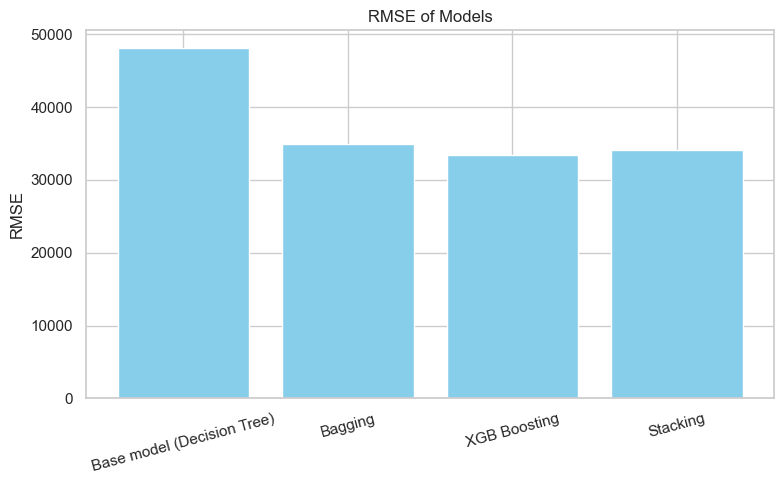

In [57]:
plt.figure(figsize=(8, 5))
plt.bar(x, rmses, color='skyblue')
plt.xticks(x, model_names, rotation=15)
plt.title('RMSE of Models')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()


## MAE

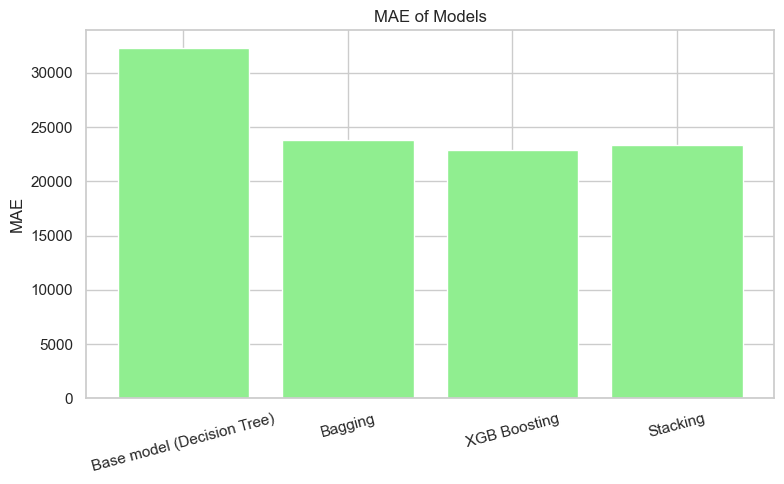

In [58]:


plt.figure(figsize=(8, 5))
plt.bar(x, maes, color='lightgreen')
plt.xticks(x, model_names, rotation=15)
plt.title('MAE of Models')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()


## R2_Score

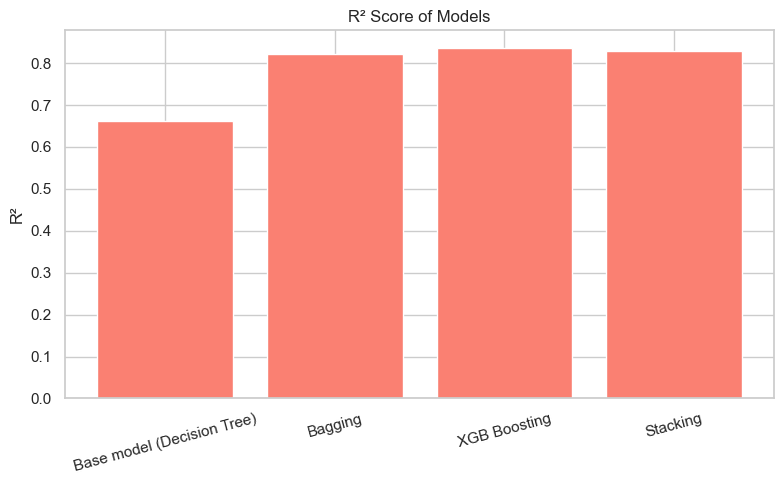

In [59]:
plt.figure(figsize=(8, 5))
plt.bar(x, r2_scores, color='salmon')
plt.xticks(x, model_names, rotation=15)
plt.title('R² Score of Models')
plt.ylabel('R²')
plt.tight_layout()
plt.show()
